In [1]:
cd ../src

/home/sankha/Documents/programs/ML/densityNN/src


# KL Divergence

This notebook is going to explore the KL divergence ...

For discrete distributions, the K-L divergence is defined by the following formula

\begin{align*}
D_{KL} = \sum_{x \in \chi} {P(x) \log {\frac {P(x)} {q(x)}}  }
\end{align*}

For continuous variables, this is represented by the integral.


In [2]:
def D_KL(p, q, epsilon=1e-5, returnVals=False):
    
    p_1 = np.clip(p, epsilon, None)
    q_1 = np.clip(q, epsilon, None)
    
    divergence = p_1 * ( np.log(p_1) - np.log(q_1) )
    
    if returnVals:
        return np.sum(divergence), divergence
    
    return np.sum(divergence)

In [8]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [4]:
def normal(theta, mu, sigma):
    '''
    theta (nd-array) (N, d): N values of d-dimensional space of thetas
    mu (nd array) (1, d): d dimensional values for the d dimensions
    sigma (nd array) (1, d): the diagonal of the covariance matrix (just for simplifying the diagonal)
    '''
    
    d = len(mu.flatten())
    theta_1 = (theta - mu) **2 /(2 * sigma )
    theta_1 = -1 * theta_1.sum(axis=1)
    
    det = sigma.prod()
    
    prob =  np.exp( theta_1 ) / np.sqrt( (2 * np.pi)**d * det )
    
    return prob


## Examples of getting distributions over here ...

First, a 1D case ...

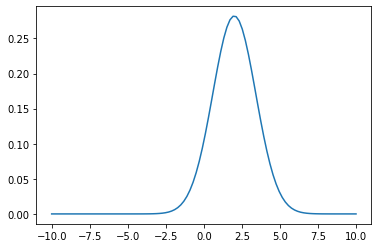

0.9899999951196327


In [5]:
theta = np.linspace(-10, 10, 100).reshape((-1, 1))
mu    = np.array([2]).reshape((1,-1))
sigma = np.array([2]).reshape((1,-1))

prob = normal( theta, mu, sigma )
plt.plot( theta.flatten(), prob )
plt.show()
plt.close('all')
print(prob.sum() * 20/100)

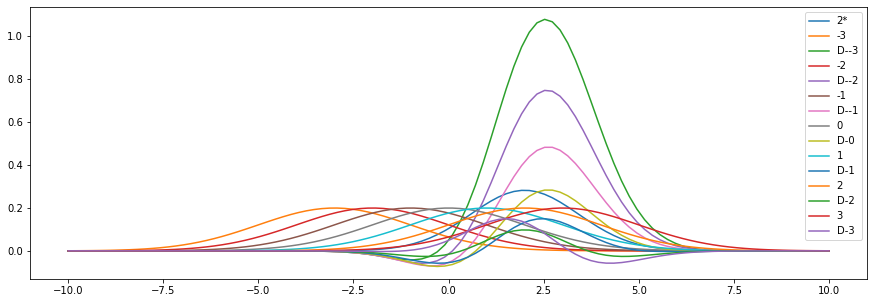

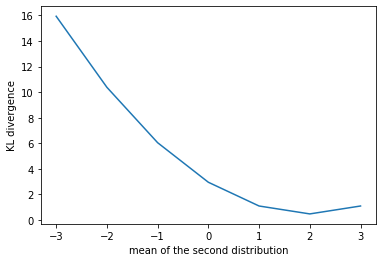

In [6]:
theta = np.linspace(-10, 10, 100).reshape((-1, 1))
mu_1  = np.array([2]).reshape((1,-1))
sigma_1 = np.array([2]).reshape((1,-1))
mu_2  = np.array([-3]).reshape((1,-1))
sigma_2 = np.array([4]).reshape((1,-1))

plt.figure(figsize=(15, 5))
prob_1 = normal(theta, mu_1, sigma_1)
plt.plot(theta.flatten(), prob_1, label='2*' )

divs = []
ms = [-3, -2, -1, 0, 1, 2, 3]
for m in ms:
    mu_2  = np.array([m]).reshape((1,-1))
    prob_2 = normal(theta, mu_2, sigma_2)

    div, div_all = D_KL(prob_1, prob_2, returnVals=True)
    divs.append( div )

    plt.plot(theta.flatten(), prob_2, label=f'{m}' )
    plt.plot(theta.flatten(), div_all, label=f'D-{m}' )
    
plt.legend()

plt.figure()
plt.plot(ms, divs)
plt.xlabel('mean of the second distribution')
plt.ylabel('KL divergence')

plt.show()
plt.close()

# Optimization

Now that we see how the KL divergence decreases with the convergence between the two probability functions, is it possible to create an optimizer that will provide a Gaussian function that minimized the distance between *any* given function and the returned Gaussian function? The answer is, of course. This will be explored in the next section ...

In [49]:
class OptKL:
    
    def __init__(self, p, theta):
        '''
        p (1d-array) (N,) : The values for the provided thetas
        theta (nd-array): (N, d) N values of theta of d-dimensions
            over which the value of sigma is to be calculated for
            obtaining the KL divergence
        '''
        
        self.p = p
        self.theta = theta
        self.d = theta.shape[1]
        self.mu = None
        self.sigma = None
        self.q = None
        
        return
    
    def D_KL(self, p, q, epsilon=1e-5, returnVals=False):
        p_1 = np.clip(p, epsilon, None)
        q_1 = np.clip(q, epsilon, None)
        divergence = p_1 * ( np.log(p_1) - np.log(q_1) )
        if returnVals:
            return np.sum(divergence), divergence

        return np.sum(divergence)
    
    def normal(self, theta, mu, sigma):
        '''
        theta (nd-array) (N, d): N values of d-dimensional space of thetas
        mu (nd array) (1, d): d dimensional values for the d dimensions
        sigma (nd array) (1, d): the diagonal of the covariance matrix (just for simplifying the diagonal)
        '''

        d = len(mu.flatten())
        theta_1 = (theta - mu) **2 /(2 * sigma )
        theta_1 = -1 * theta_1.sum(axis=1)

        det = sigma.prod()

        prob =  np.exp( theta_1 ) / np.sqrt( (2 * np.pi)**d * det )

        return prob
    
    def minFunc(self, x, *args):
        
        mu = x[:self.d].reshape(1, -1)
        sigma = x[self.d:].reshape(1, -1)
        
        q = self.normal(self.theta, mu, sigma)
        result = D_KL( self.p, q)
        
        return result
    
    def optimize(self, mu0, *args, **kwargs):
        '''
        mu0 (nd-array) (1, d): the initial value from which to start calculations
        funcArgs (tuple): other args to be passed to the function `p`
        args: other arguments to be passed to the `minimize` function
        kwargs: other kwyword arguments to be passed to the minimize function
        '''
        
        sigma0 = np.ones( mu0.shape )
        x0 = np.hstack( (mu0, sigma0) )
        
        result = minimize( self.minFunc, x0, *args, **kwargs )
        x = result['x']
        
        self.mu = x[:self.d].reshape(1, -1)
        self.sigma = x[self.d:].reshape(1, -1)
        
        self.q = self.normal(self.theta, self.mu, self.sigma)
        
        return self.q
    

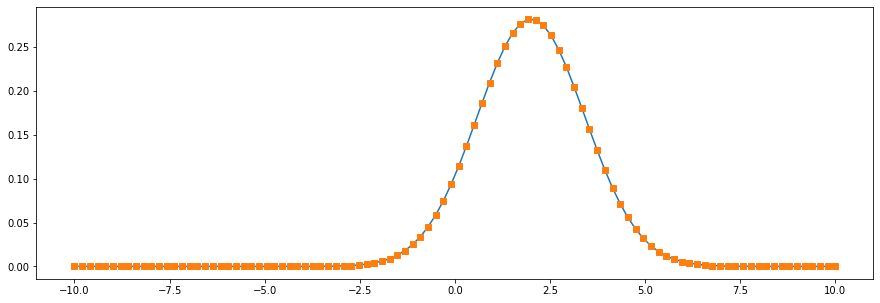

In [52]:
theta = np.linspace(-10, 10, 100).reshape((-1, 1))
mu_1  = np.array([2]).reshape((1,-1))
sigma_1 = np.array([2]).reshape((1,-1))

plt.figure(figsize=(15, 5))
prob_1 = normal(theta, mu_1, sigma_1)
plt.plot(theta.flatten(), prob_1, label='2*' )

mu0 = np.array([-1]).reshape((1, -1))

optKL = OptKL(prob_1, theta)
q_optimized = optKL.optimize(mu0)

plt.plot( theta.flatten(), q_optimized, 's') 


plt.show()
plt.close('all')

Now for the 2D case:

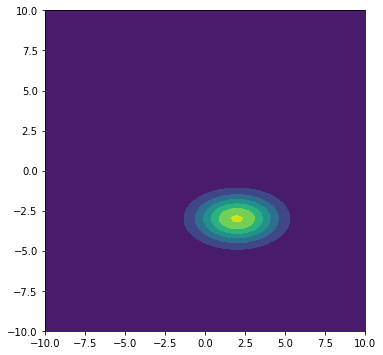

0.9800985925765558


In [7]:
X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
theta = np.array(list(zip(X.flatten(), Y.flatten())))

mu    = np.array([2, -3]).reshape((1,-1))
sigma = np.array([3, 1]).reshape((1,-1))

prob = normal( theta, mu, sigma )
prob = prob.reshape(100, 100)

plt.figure(figsize=(5,5))
plt.axes([0.1, 0.1, 0.89, 0.89])
plt.contourf(X, Y, prob)
plt.show()
plt.close('all')

print( prob.sum() * (20/100)**2 )